**SRH: SIFT RANSAC Homography**

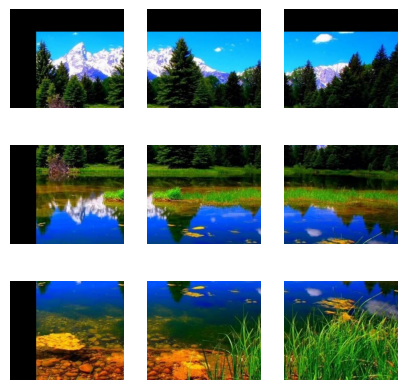

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Assuming images is a list of your 9 images
images = []
for filename in os.listdir('outputs'):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Add or modify to suit your image file types
        img = Image.open(os.path.join('outputs', filename))
        images.append(img)

fig, axs = plt.subplots(3, 3, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(images[i])
    ax.axis('off')

plt.show()

In [23]:
import skimage.feature
import numpy as np
from PIL import Image

# Load images
folder_path = "outputs"
files = os.listdir(folder_path)
images = [Image.open(os.path.join(folder_path, file)) for file in files]

In [30]:
import os
import skimage.feature
import numpy as np
from PIL import Image
from sklearn.neighbors import NearestNeighbors

class ImageStitcher:
    def __init__(self, images):
        self.images = images
        self.keypoints = []
        self.descriptors = []
        self.matches = []
        self.homographies = []
        self.warped_images = []

    def detect_and_match_features(self):
        """
        Detect and match features between images using SIFT.
        """
        for image in self.images:
            img_array = np.array(image.convert('L'))  # Convert to grayscale
            kp, desc = skimage.feature.detect_and_compute(img_array, skimage.feature.SIFT())
            self.keypoints.append(kp)
            self.descriptors.append(desc)

        self.matches = match_descriptors(self.descriptors)

    def estimate_homographies(self):
        """
        Estimate homographies between pairs of images using RANSAC.
        """
        for match in self.matches:
            src_pts, dst_pts = match
            H, _ = skimage.transform.ransac((src_pts, dst_pts), skimage.transform.SimilarityTransform, min_samples=4, residual_threshold=2)
            self.homographies.append(H.params)

    def warp_images(self):
        """
        Warp and align images onto a common canvas using estimated homographies.
        """
        for image, H in zip(self.images, self.homographies):
            img_array = np.array(image)
            warped = skimage.transform.warp(img_array, H)
            self.warped_images.append(warped)

    def create_mosaic_grid(self, blend_func):
        """
        Determine the grid layout and blend the warped images into a mosaic.
        """
        composite = create_mosaic_grid(self.warped_images, blend_func)
        return composite
    
def match_descriptors(descriptors):
    """
    Match descriptors between pairs of images.
    """
    matches = []
    for i in range(len(descriptors) - 1):
        for j in range(i + 1, len(descriptors)):
            match = match_descriptors_pair(descriptors[i], descriptors[j])
            matches.append(match)
    return matches

def match_descriptors_pair(desc1, desc2):
    """
    Match descriptors between a pair of images.
    """
    matcher = NearestNeighbors(n_neighbors=2, algorithm='auto')
    matcher.fit(desc2)
    distances, indices = matcher.kneighbors(desc1)
    good_matches = []
    for i, (d1, d2) in enumerate(zip(distances[:, 0], distances[:, 1])):
        if d1 < 0.7 * d2:
            good_matches.append((desc1[i], desc2[indices[i, 0]]))
    src_pts = np.array([pt[0].pt for pt in good_matches])
    dst_pts = np.array([pt[1].pt for pt in good_matches])
    return src_pts, dst_pts

def create_mosaic_grid(warped_images, blend_func):
    """
    Blend the warped images into a mosaic grid.
    """
    # Determine grid layout
    grid_shape = (2, 2)  # Assuming a 2x2 grid for simplicity

    # Blend images using the provided blend_func
    mosaic = blend_images(warped_images, grid_shape, blend_func)

    return mosaic

def blend_images(images, grid_shape, blend_func):
    """
    Blend the images into a mosaic grid using the provided blend function.
    """
    rows, cols = grid_shape
    mosaic = Image.new('RGB', (images[0].shape[1] * cols, images[0].shape[0] * rows))

    for row in range(rows):
        for col in range(cols):
            img_idx = row * cols + col
            if img_idx < len(images):
                img = Image.fromarray(images[img_idx])
                x, y = col * images[0].shape[1], row * images[0].shape[0]
                mosaic.paste(img, (x, y))

    # Apply blending function to overlapping regions
    for row in range(rows - 1):
        for col in range(cols - 1):
            img1 = mosaic.crop((col * images[0].shape[1], row * images[0].shape[0], (col + 1) * images[0].shape[1], (row + 1) * images[0].shape[0]))
            img2 = mosaic.crop(((col + 1) * images[0].shape[1], (row + 1) * images[0].shape[0], (col + 2) * images[0].shape[1], (row + 2) * images[0].shape[0]))
            blended = blend_func(img1, img2)
            mosaic.paste(blended, (col * images[0].shape[1], row * images[0].shape[0]))

    return mosaic

# Usage
folder_path = "outputs"
files = os.listdir(folder_path)
images = [Image.open(os.path.join(folder_path, file)) for file in files]

stitcher = ImageStitcher(images)
stitcher.detect_and_match_features()
stitcher.estimate_homographies()
stitcher.warp_images()

# Define a simple blending function
def blend_images(img1, img2):
    # Implement blending logic
    blended = Image.blend(img1, img2, 0.5)
    return blended

mosaic = stitcher.create_mosaic_grid(blend_images)
mosaic.save('mosaic.jpg')

AttributeError: No skimage.feature attribute detect_and_compute